# Figure 1B,C: Tracking optogenetically-induced synthetic RhoA wave

In [75]:
import napari
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from skimage import io, transform
from skimage.util import montage
from arcos4py.tools import remove_image_background, track_events_image
from arcos4py.tools._cleandata import blockwise_median
from napari_timestamper import render_as_rgb, save_image_stack
import os

## Function Definitions

In [ ]:
def plot_sel_frames(in_im, in_npanels = 2, in_title = "", in_plot_size = (12,8)):
    fig, axarr = plt.subplots(1, 1, figsize=in_plot_size)

    arr_sel_frames = np.linspace(0, len(in_im) - 1, in_npanels).astype(np.int32)
    in_im_sel = in_im[arr_sel_frames]

    im_montage = montage(
        in_im_sel,
        padding_width=10,
        fill=np.max(arr_sel_frames),
        grid_shape=(1, in_im_sel.shape[0]),
    )

    # fig.axis('off')
    axarr.set_axis_off()
    axarr.set_title(in_title)
    for i, frame in enumerate(arr_sel_frames):
        axarr.text(
            10 + i * (im_montage.shape[1] // in_im_sel.shape[0]), 
            10, 
            f"Frame {frame}", 
            color='white', 
            fontsize=12, 
            ha='left', 
            va='top'
        )
    axarr.imshow(im_montage, cmap="gray", vmin=18, vmax=512)

    plt.show()
    
def project_labels(label_image, axis, y_scale=10):
  """
  Projects a label image along a specified axis.

  Args:
    label_image: A NumPy array of shape (t, y, x) representing the label image.
    axis: An integer specifying the axis along which to project (0 for time, 1 for y, 2 for x).
    y_scale: integer how many times the y_axis should be sampled

  Returns:
    A NumPy array of shape (y, t) or (x, t) representing the projected label image.
  """
  if axis >= label_image.ndim:
      raise ValueError("Invalid axis: {}".format(axis))
  
  projection = label_image.max(axis=axis)
  # projection = np.where(projection == 0, np.nan, projection)
  
  return np.repeat(projection, y_scale, axis=0)

# Creating a simplified Python dictionary to map the three integers to their respective Hex color codes
SIMPLE_COLOR_MAPPING = {
    1: '#00A896',  # Blue-Green
    2: '#FF6F61',  # Coral
    3: '#FFCC00',   # Golden Yellow
    4: '#A0E7E5',   # Light Blue
    5: '#FFB5A7',   # Light Coral
    6: '#FFEC99',   # Light Golden Yellow
    7: '#C1F0F6',   # Light Blue-Green
    8: '#FFD3B5',   # Light Salmon
    9: '#FFEEAD',   # Light Goldenrod Yellow
    10: '#A2D5C6',  # Light Sea Green
}

PIXEL_SIZE = 0.21666  # microns

In [ ]:
# change the paths to the data and output directories
DATA_DIR = "data"
INPUT_DIR = os.path.join(DATA_DIR, "2_synthetic_rhoa_wave/raw")
PLOTS_DIR = os.path.join(DATA_DIR, "2_synthetic_rhoa_wave/output-plots")
OUTPUT_DIR = os.path.join(DATA_DIR, "2_synthetic_rhoa_wave/output")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Load images

In [ ]:
rGBD = io.imread(os.path.join(INPUT_DIR,'2x_rGBD_dTomato.tif'))
stim = io.imread(os.path.join(INPUT_DIR,'stimulation.tif'))

In [54]:
# Show time-lapse in napari image viewer
viewer = napari.Viewer()
viewer.add_image(rGBD, name='rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.5])
viewer.add_image(stim, name='stim', colormap='I Purple', blending='minimum', contrast_limits=[stim.min()*1, stim.max()*0.25])

<Image layer 'stim' at 0x1a03c7f9f40>

In [55]:
# 4x4 binning for performace; downscaling from 1024x1024 to 256x256
rGBD_binned = blockwise_median(rGBD, (1, 4,4))

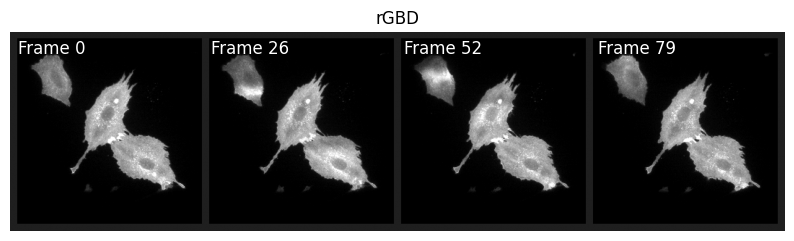

In [56]:
plot_sel_frames(rGBD_binned, 4, "rGBD", (10,3))

In [57]:
rGBD_bckg_rem = remove_image_background(rGBD_binned, 
                                        filter_type='median', 
                                        size=(60,1,1), 
                                        crop_time_axis=False)

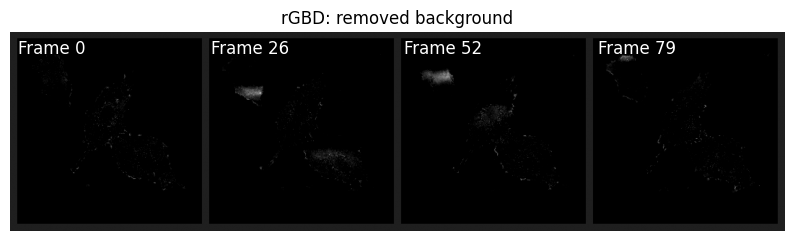

In [58]:
plot_sel_frames(rGBD_bckg_rem, 4, "rGBD: removed background", (10,3))

## Track events

In [71]:
binary_img = rGBD_bckg_rem > 20

In [72]:
events = track_events_image(binary_img, eps=8, min_clustersize=150,)

100%|██████████| 80/80 [00:02<00:00, 32.17it/s]


In [ ]:
# use skimage rescale to get the events in the original image size
events_upscaled = transform.rescale(events.astype(int), 
                                    (1, 4, 4), 
                                    order=0, 
                                    preserve_range=True, 
                                    mode='constant')

In [ ]:
viewer.add_labels(events_upscaled, name='events', colormap=SIMPLE_COLOR_MAPPING)

c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


<Labels layer 'events' at 0x1a042f92270>

## Render sample images

In [62]:
arr_sel_frames = np.linspace(0, 60, 4, dtype=int)

rgb_events = []
rgb_rGBD_stim = []
viewer.layers['rGBD'].visible = True
viewer.layers['stim'].visible = True
viewer.layers['events'].visible = True
for img in arr_sel_frames:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers['events'].visible = False

for img in arr_sel_frames:
    viewer.dims.set_current_step(0, img)
    rgb_rGBD_stim.append(render_as_rgb(viewer, upsample_factor=1))

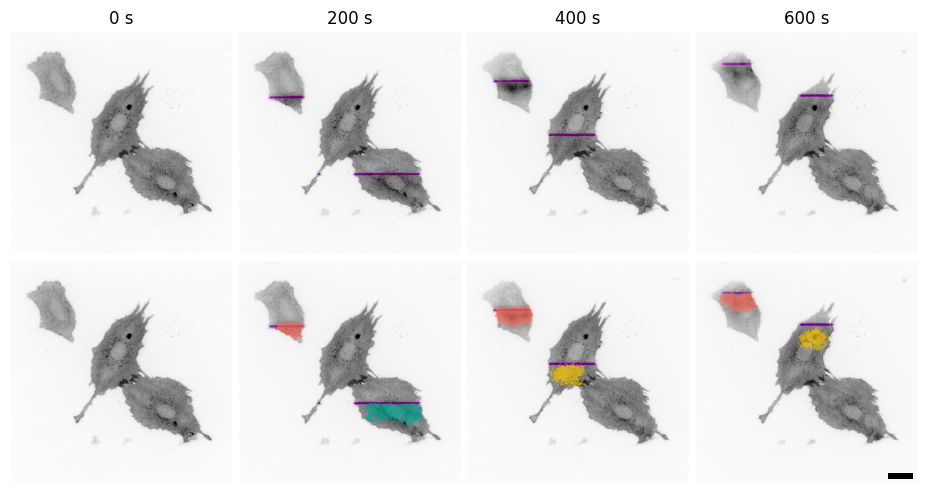

In [ ]:
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(2,4, figsize=(10,5))

for idx, val in enumerate(arr_sel_frames):
    ax[0, idx].imshow(rgb_rGBD_stim[idx])
    ax[0, idx].axis('off')
    ax[0, idx].set_title(f'{val*10} s')

for idx, val in enumerate(arr_sel_frames):
    ax[1, idx].imshow(rgb_events[idx])
    ax[1, idx].axis('off')
    if val == arr_sel_frames[-1]:
        scalebar = ScaleBar(PIXEL_SIZE, "um", length_fraction=0.2, location='lower right', box_alpha=0, scale_loc="none", width_fraction=0.025)
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-4)
plt.savefig(os.path.join(PLOTS_DIR,'montage-sel-frames.svg'), dpi=600)

c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(
C:\Users\benig\AppData\Local\Temp\ipykernel_29964\1146407294.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x:.0f}' for x in x_ticks*0.21666])


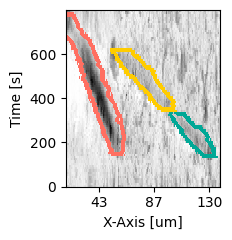

In [ ]:
viewer_projection = napari.Viewer()

viewer_projection.add_image(project_labels(transform.rescale(rGBD_bckg_rem, (1,4,4), mode='constant'), 2), colormap='gray_r')
l = viewer_projection.add_labels(project_labels(events_upscaled, 2), opacity=1,colormap=SIMPLE_COLOR_MAPPING)
l.contour = 20
noodles_rbg_rGBD = render_as_rgb(viewer_projection, upsample_factor=1)
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(noodles_rbg_rGBD, cmap='tab20', vmin=1, vmax=3, interpolation='none')

ax.invert_yaxis()
ax.set_xlim(100, 800)
x_ticks = ax.get_xticks()
ax.set_xticklabels([f'{x:.0f}' for x in x_ticks*PIXEL_SIZE])
ax.set_ylabel('Time [s]')
ax.set_xlabel('X-Axis [um]')
ax.set_aspect(1)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'noodles_bg_removed.svg'), dpi=600)

C:\Users\benig\AppData\Local\Temp\ipykernel_29964\2694426543.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x:.0f}' for x in x_ticks*0.21666])


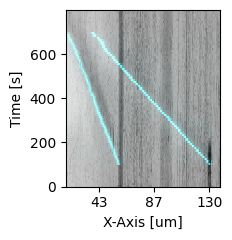

In [ ]:
viewer_projection = napari.Viewer()
viewer_projection.add_image(project_labels(rGBD, 2), colormap='gray_r')
viewer_projection.add_image(project_labels(stim, 2), colormap='cyan', blending='additive')
max_rGBD = render_as_rgb(viewer_projection, upsample_factor=1)
viewer_projection.close()
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(max_rGBD, interpolation='none')
ax.invert_yaxis()
ax.set_xlim(100, 800)
x_ticks = ax.get_xticks()
ax.set_xticklabels([f'{x:.0f}' for x in x_ticks*0.21666])
ax.set_ylabel('Time [s]')
ax.set_xlabel('X-Axis [um]')
# set aspect ratio to 1
ax.set_aspect(1)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'raw_max_proj.svg'), dpi=600)

### Save the movie

In [ ]:
_stack = render_as_rgb(viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR, '/stack.tif'), _stack)

### Export RGB tifs

In [73]:
# upsample binary, detrended image to original size
binary_upscaled = transform.rescale(binary_img.astype(int), (1, 4, 4), order=0, preserve_range=True, mode='constant')
rGBD_bckg_rem_upscaled = transform.rescale(rGBD_bckg_rem, (1, 4, 4), order=0, preserve_range=True, mode='constant')


In [ ]:
rgb_tiff_viewer = napari.Viewer()
l1 = rgb_tiff_viewer.add_image(rGBD, name='rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.5])
l2 = rgb_tiff_viewer.add_image(stim, name='stim', colormap='I Purple', blending='minimum', contrast_limits=[stim.min()*1, stim.max()*0.25])
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR,'rgb_stim_rgbd.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)
rgb_tiff_viewer.layers.remove(l2)

l1 = rgb_tiff_viewer.add_image(rGBD_bckg_rem_upscaled, name='detrended rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.25])
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR,'rgb_detrended_rgbd.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)

l1 = rgb_tiff_viewer.add_image(binary_upscaled, name='binary', colormap='gray_r', blending='additive')
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)
io.imsave(os.path.join(OUTPUT_DIR,'rgb_binary.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)

l1 = rgb_tiff_viewer.add_image(rGBD, name='rGBD', colormap='gray_r', blending='additive', contrast_limits=[rGBD.min()*1, rGBD.max()*0.5])
l2 = rgb_tiff_viewer.add_labels(events_upscaled, name='events', colormap=SIMPLE_COLOR_MAPPING)
rgb = render_as_rgb(rgb_tiff_viewer, axis=0, upsample_factor=1)

io.imsave(os.path.join(OUTPUT_DIR,'rgb_events.tif'), rgb)

rgb_tiff_viewer.layers.remove(l1)
rgb_tiff_viewer.layers.remove(l2)

rgb_tiff_viewer.close()


c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(
